# Carpet Claim Data Analysis
Investigate the defects in the delamination testing data using one monthe data (Aug 2017) at various intervals

R1: Accumulated Customer sales + claims ... Nov 2017

- #Claims

- $/Claim

- #Sales

- $/Sale

- $Claim /$Sale

R2: Add product info...Dec 2017

- Customer
 - #Sales
 - $/Sale
 

- Claim
 - Product Style
 - Product Size
 - Product Backing
 - Product Color
 - $/claim
 - Claim/Total Sale

In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import os, inspect
import copy
import csv
import pickle
%matplotlib inline 
import pylab
import matplotlib.pylab as plt
import matplotlib.image as img
import scipy.stats as stats
import seaborn as sns
from IPython.core.display import HTML 
from sklearn.preprocessing import scale
from bokeh.io import show, output_file
from bokeh.plotting import figure
#from bokeh.charts import Bar, BoxPlot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from collections import Counter

# Define functions

In [2]:
#define a function to visualize results
def _plot_value_series(self, dt, factor, yName, iplot, varDefect=None):
    #self is data array
    nrow = len(self)
    #Feature
    self_max = np.max(self)
    self_min = np.min(self)
    self_mu = np.mean(self)
    self_std = np.std(self)
    upper_limit = self_mu + factor * self_std;
    lower_limit = self_mu - factor * self_std;
    
    #create a vector
    ts = range(nrow)
 
    #check timepoints
    len_time = len(dt)
    if len_time > nrow or len_time < nrow:
        dt = ts
        
    fig = plt.figure(figsize=(11,4))    
    ax = plt.subplot(111)  
    
     #plt.plot(dt,X,'k-')
    s1 = np.random.rand(*dt.shape) * 80 + 50
    plt.scatter(dt,self, s1, c="k", alpha = 0.8)  
    #plt.plot(dt,self,'k-')
    
    #####horizontal line
    upper_limit_data = np.array([upper_limit for i in range(len(dt))])
    plt.plot(dt, upper_limit_data, 'r--', label='Upper Limit') 

    lower_limit_data = np.array([lower_limit for i in range(len(dt))])
    plt.plot(dt, lower_limit_data, 'g--', label='Lower Limit') 
    
    #ax.axhline(y=upper_limit, xmin=dt[0], xmax = dt[len(dt)-1],color = 'b', label='Upper limit')
    #ax.axhline(y=lower_limit, xmin=dt[0], xmax = dt[len(dt)-1],color='g', label='Lower limit')
    plt.ylabel(yName)
    plt.xlabel('Time')
    
    # retrieving the indices where "sng > max" using np.where    
    upperIndex = []
    upperCnt = 0.0
    lowerIndex = []
    lowerCnt = 0.0
    for index, item in enumerate(self):        
        if item > upper_limit:
            upperCnt += 1.0
            upperIndex.append(index)
            plt.plot(dt[index],item, 'bs') 
        else:
            if item < lower_limit:
                lowerCnt += 1.0
                lowerIndex.append(index)
                plt.plot(dt[index],item, 'ms')           
            
        if varDefect is not None and varDefect[index] > 0:
            s = np.pi * varDefect[index]**2 #np.random.rand(*dt.shape) * 80 + 50
            plt.scatter(dt[index],item,s, c="r", alpha = 0.5)         
            
    # Now add the legend with some customizations.
    legend = ax.legend(loc='best', shadow=True)

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.0)  # the legend line width
    
    plt.show()
    
    # display the failure data points
    if (iplot == 1) and (upperCnt > 0.0):
        print('Number of above upper limit points = ', upperCnt)
        print('Above upperlimit points:', upperIndex)        
    
    if (iplot == 1) and (lowerCnt > 0.0):
        print('Number of below lowerlimit points = ', lowerCnt)
        print('Below lowerlimit points:', lowerIndex)    

In [3]:
#Visualizing Interrelationships between Attributes - scatter
def _plot_multivariate(self):
    plt.figure(figsize=(14,14))
    pd.plotting.scatter_matrix(self, diagonal="kde") 
    plt.tight_layout()
    plt.show()

In [4]:
#Visualizing Attribute and Label Correlations Using a Heat Map
#calculate correlations between real-valued attributes
def _plot_heatmap(self):
    xcorMat = pd.DataFrame(self.corr())
    #visualize correlations using heatmap
    plt.pcolor(xcorMat)
    plt.show() 

In [5]:
# plot quantile-quantile of data   
def _plot_QQ(self):    
    #plot quantile-quantile of a timeseries
    stats.probplot(self, dist="norm", plot=plt)
    plt.show() 

In [6]:
def _plot_boxplot(self):
    #plot box plot of one variable or matrix
    plt.figure(figsize=(11,11)) 
    plt.boxplot(self, 0, 'rD', 0, 0.75)    
    plt.show()

In [7]:
def _timeseries_plot(self):
    #plot time series of univaraite or multivariable
    plt.figure(figsize=(15,4))
    ax = self.plot()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()
    plt.show()

In [8]:
# clean latex type
def _read_tagData(dataModel, tag, thred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] == thred, :]
    #print(dataModel.loc[:,['GFROLL', 'GFLTYP','delamIndex', 'delamMin']], len(dataModel_output.GFROLL))
    return dataModel_output

In [9]:
def _read_upper(dataModel, tag, upperThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] <= upperThred,:]
    return dataModel_output
        
def _read_lower(dataModel, tag, lowerThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] >= lowerThred,:]
    return dataModel_output

def _drop_rows(dataModel, tag, thred):
    #drop other GFTYPE
    # thred can be a numerical or string   
    
    dataModel_rem = dataModel[dataModel[tag] != thred]
    return dataModel_rem

In [10]:
def class_info(classes):
    counts = Counter(classes)
    total = sum(list(counts.values()))
    
    cper = []
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], counts[cls]/total*100))
        cper.append(counts[cls]/total)
    
    return counts, cper

In [11]:
 def _create_filename(path, fname, prefix ='', affix = '.csv'):
        # create new file name
                    
        output_name = prefix + fname + affix        
        foutput_name = os.path.join(path, '', output_name)
              
        return foutput_name

In [12]:
def _plot_classbar(x_claims, y_pos):
    fig, ax = plt.subplots()

    ax.bar(y_pos, x_claims, align='center', color=['red', 'blue'])
   
    pclaim = [y/sum(x_claims) for y in x_claims]
    for i, (v, p) in enumerate(zip(x_claims, pclaim)):
        ax.text(i, v-5, str(v), color='black', fontweight='bold')

    ax.set_xticks(y_pos, objects)
    plt.ylabel('#Claims')
    plt.title('Claims Type')

    plt.show()

In [13]:
# models
class label_encoder(object):
    def fit_pd(self,df,cols=[]):
        '''
        fit all columns in the df or specific list. 
        generate a dict:
        {feature1:{label1:1,label2:2}, feature2:{label1:1,label2:2}...}
        '''
        if len(cols) == 0:
            cols = df.columns
        self.class_index = {}
        for f in cols:
            uf = df[f].unique()
            self.class_index[f] = {}
            index = 1
            for item in uf:
                self.class_index[f][item] = index
                index += 1
    
    def fit_transform_pd(self,df,cols=[]):
        '''
        fit all columns in the df or specific list and return an update dataframe.
        '''
        if len(cols) == 0:
            cols = df.columns
        newdf = copy.deepcopy(df)
        self.class_index = {}
        for f in cols:
            uf = df[f].unique()
            self.class_index[f] = {}
            index = 1
            for item in uf:
                self.class_index[f][item] = index
                index += 1
                
            newdf[f] = df[f].apply(lambda d: self.update_label(f,d))
        return newdf
    
    def transform_pd(self,df,cols=[]):
        '''
        transform all columns in the df or specific list from lable to index, return an update dataframe.
        '''
        newdf = copy.deepcopy(df)
        if len(cols) == 0:
            cols = df.columns
        for f in cols:
            if f in self.class_index:
                newdf[f] = df[f].apply(lambda d: self.update_label(f,d))
        return newdf
                
    def update_label(self,f,x):
        '''
        update the label to index, if not found in the dict, add and update the dict.
        '''
        try:
            return self.class_index[f][x]
        except:
            self.class_index[f][x] = max(self.class_index[f].values())+1
            return self.class_index[f][x]

In [14]:
# set working directory
#curPath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
#parentDir = os.path.split(curPath)[0];
parentDir = 'C:/Users/E154709/Desktop/Mohawk/Claims'
os.chdir(parentDir)

outputPath = parentDir + '/Output/'
if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    
codePath = parentDir + '/Code/'
if not os.path.exists(codePath):
    os.mkdir(codePath)
    
dataPath = parentDir + '/Data/'
if not os.path.exists(dataPath):
    os.mkdir(dataPath)
    
modelPath = parentDir + '/Model/'
if not os.path.exists(modelPath):
    os.mkdir(modelPath)

In [15]:
#create data file
    
fname = 'rawData_con'
frawData = _create_filename(dataPath,fname)
print(frawData)

fname = 'processedData_con'
fprocData = _create_filename(dataPath,fname)
print(fprocData)

fname = 'modelData2'
fmodelData = _create_filename(dataPath,fname)
print(fmodelData)

fname = 'SmartClaim'
prefix = 'encoder_'
affix = '.pkl'
fmodelPara = _create_filename(modelPath,fname, prefix, affix)
print(fmodelPara)

C:/Users/E154709/Desktop/Mohawk/Claims/Data/rawData_con.csv
C:/Users/E154709/Desktop/Mohawk/Claims/Data/processedData_con.csv
C:/Users/E154709/Desktop/Mohawk/Claims/Data/modelData2.csv
C:/Users/E154709/Desktop/Mohawk/Claims/Model/encoder_SmartClaim.pkl


# Import and Consolidate Claim Data 

Run this section only if you have not consolidated the raw data. Otherwise, directly go to the section of claim data processing

In [16]:
# Read Claims Data
import chardet
    
Claim_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims.csv'
ClaimsData = pd.read_csv(Claim_dataPath, encoding='latin1')  # Read the claims data

ClaimReason_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Reason.csv'
ClaimReason = pd.read_csv(ClaimReason_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimStatus_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Status.csv'
ClaimStatus = pd.read_csv(ClaimStatus_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimType_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Type.csv'
ClaimType = pd.read_csv(ClaimType_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimCustomer_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/SLS_Customer.csv'
ClaimCustomer = pd.read_csv(ClaimCustomer_dataPath, encoding='latin1')  # Read the claimReason data

ClaimProduct_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Product.csv'
ClaimProduct = pd.read_csv(ClaimProduct_dataPath, encoding='latin1')  # Read the claimProduct data

MemoryError: 

In [17]:
#check the claim data
print(ClaimsData.describe())
print(ClaimsData.shape)
print(ClaimsData.columns.values)

       FACT_CUSTOMER_CLAIMS_PK  DIM_DIVISION_CUSTOMER_PK  \
count             3.114910e+05              3.114910e+05   
mean              1.238682e+07              2.042229e+06   
std               7.553653e+05              2.644398e+05   
min               1.747000e+03              1.257705e+06   
25%               1.235823e+07              1.984710e+06   
50%               1.244263e+07              2.155343e+06   
75%               1.252643e+07              2.212648e+06   
max               1.261002e+07              2.318022e+06   

       DIM_DIVISION_CUSTOMER_GK  CLAIM_DATE_PK  CLAIM_STATUS_DATE_PK  \
count             311491.000000   3.114910e+05          3.114910e+05   
mean              282254.679564   2.017000e+07          2.017061e+07   
std                69499.110024   3.625091e+04          3.353591e+02   
min                54987.000000  -1.000000e+00          2.010052e+07   
25%               242550.000000   2.017030e+07          2.017040e+07   
50%               268953.00

In [18]:
#check the claim data
print(ClaimReason.describe())
print(ClaimReason.shape)
print(ClaimReason.columns.values)

       DIM_CLAIM_REASON_PK  DIM_CLAIM_REASON_GK
count             566.0000           566.000000
mean              280.5000           281.496466
std               163.5344           163.540515
min                -2.0000            -2.000000
25%               139.2500           140.250000
50%               280.5000           281.500000
75%               421.7500           422.750000
max               563.0000           564.000000
(566, 13)
['DIM_CLAIM_REASON_PK' 'DIM_CLAIM_REASON_GK' 'CLAIM_REASON_CD'
 'CLAIM_REASON_DESC' 'CLAIM_REASON_SHORT_DESC' 'CLAIM_DEPARTMENT_CD'
 'QUALITY_RELATED_CD' 'ENTERPRISE_ENTITY_CD' 'SOURCE_SYSTEM_CD'
 'DELETE_IND' 'CREATE_DTM' 'UPDATE_DTM' 'LANDING_DTM']


In [19]:
print(ClaimProduct.shape)

(394402, 120)


In [20]:
ClaimProduct_pos = ClaimProduct[ClaimProduct['DIM_FINISHED_PRODUCT_SELL_GK'] > 0]
ClaimProduct_neg = ClaimProduct[ClaimProduct['DIM_FINISHED_PRODUCT_SELL_GK'] < 0]
print(ClaimProduct_pos.shape)
print(ClaimProduct_neg.shape)
print(ClaimProduct_neg.shape[0]/ClaimProduct.shape[0])

(226108, 120)
(168294, 120)
0.426706761121901


[226108, 168294] [0 1]


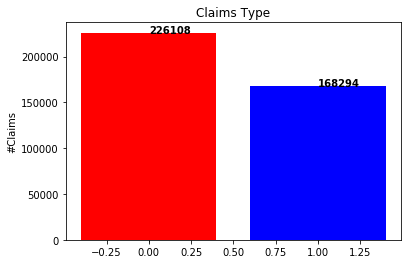

In [22]:
objects = ('Product_Pos', 'Product_Neg')
y_p = np.arange(len(objects))
product_num = [ClaimProduct_pos.shape[0], ClaimProduct_neg.shape[0]]
print(product_num, y_p)
pcent = [y/sum(product_num) for y in product_num]
_plot_classbar(product_num, y_p)

In [26]:
#check the claim Product data
print(ClaimProduct_pos.describe())
print(ClaimProduct_pos.shape)
print(ClaimProduct_pos.columns.values)

       DIM_FINISHED_PRODUCT_SELL_GK  MATERIAL_BRAND_GROUP_SORT_NUM  \
count                  2.261080e+05                  128565.000000   
mean                   6.245426e+06                     389.632661   
std                    1.492172e+06                    1372.167578   
min                    4.675180e+05                      10.000000   
25%                    6.086741e+06                      50.000000   
50%                    6.739062e+06                      70.000000   
75%                    7.181805e+06                     110.000000   
max                    7.809057e+06                    9999.000000   

       FINISHED_PRODUCT_MFG_PK  CLAIM_DATE_PK  CLAIM_ENTRY_DATE_PK  \
count             2.261080e+05   2.261080e+05         2.261080e+05   
mean              1.037312e+07   2.013843e+07         2.017008e+07   
std               3.542211e+06   7.886614e+05         3.767121e+04   
min               6.000000e+02  -1.000000e+00         2.289707e+06   
25%               8

In [28]:
cp_count, cp_coer = class_info(ClaimProduct_pos.INVENTORY_STYLE_CD)

 27778:     149  =    0.1%
 27841:      39  =    0.0%
 43533:       4  =    0.0%
 27023:       1  =    0.0%
 27021:       5  =    0.0%
 59121:     155  =    0.1%
 26030:     155  =    0.1%
 27490:      10  =    0.0%
 80124:      29  =    0.0%
 27318:     270  =    0.1%
 27339:     325  =    0.1%
 1537R:       1  =    0.0%
 1541R:       2  =    0.0%
 27416:      72  =    0.0%
 26326:       2  =    0.0%
 26712:       1  =    0.0%
 3715R:       5  =    0.0%
 26767:       1  =    0.0%
 26690:       1  =    0.0%
 26720:       1  =    0.0%
 82047:      28  =    0.0%
 27044:       5  =    0.0%
 26778:       3  =    0.0%
 25578:     127  =    0.1%
 27048:     425  =    0.2%
 25532:     103  =    0.0%
 27047:     131  =    0.1%
 25494:      30  =    0.0%
 26792:       2  =    0.0%
 27011:      12  =    0.0%
 25725:     258  =    0.1%
 25108:      73  =    0.0%
 25107:      26  =    0.0%
 25110:     106  =    0.0%
 25109:      29  =    0.0%
 25444:     410  =    0.2%
 27522:     190  =    0.1%
 

 27922:    1030  =    0.5%
  C812:      47  =    0.0%
  C813:      48  =    0.0%
 32502:     160  =    0.1%
 32503:     159  =    0.1%
  2H71:      51  =    0.0%
 28088:     107  =    0.0%
 28089:     170  =    0.1%
 27941:     229  =    0.1%
 28031:      67  =    0.0%
 28032:     189  =    0.1%
 28077:     272  =    0.1%
 28039:     563  =    0.2%
 28040:     501  =    0.2%
 28041:     470  =    0.2%
 28029:     531  =    0.2%
 28011:     366  =    0.2%
 28057:     170  =    0.1%
 28051:     498  =    0.2%
 28052:     237  =    0.1%
 28086:      54  =    0.0%
 28087:     116  =    0.1%
 TOUGH:       1  =    0.0%
  2D70:       1  =    0.0%
  2D71:       1  =    0.0%
  2H67:       1  =    0.0%
  2B71:      37  =    0.0%
  2B75:      18  =    0.0%
 28090:      35  =    0.0%
  2J75:       1  =    0.0%
 28091:      15  =    0.0%
  2H83:       2  =    0.0%
  2H91:       2  =    0.0%
 27884:     145  =    0.1%
 74334:       3  =    0.0%
 74336:       1  =    0.0%
  2B77:      20  =    0.0%
 

 N2P35:       1  =    0.0%
 80534:       9  =    0.0%
 83061:      69  =    0.0%
 83064:       9  =    0.0%
  T831:       1  =    0.0%
 88553:       1  =    0.0%
 88622:       2  =    0.0%
 88623:       2  =    0.0%
 88676:       2  =    0.0%
 88646:       1  =    0.0%
 88651:       1  =    0.0%
 88679:       2  =    0.0%
 88685:       6  =    0.0%
 88686:       1  =    0.0%
 88726:       3  =    0.0%
 88773:       1  =    0.0%
 88775:       2  =    0.0%
  T837:       4  =    0.0%
  2P55:       1  =    0.0%
  2P67:       2  =    0.0%
 92766:       2  =    0.0%
 YJ39A:       1  =    0.0%
 88421:       4  =    0.0%
 88486:       9  =    0.0%
 88599:       1  =    0.0%
 88569:       2  =    0.0%
 88588:       2  =    0.0%
 88589:       1  =    0.0%
 88617:       2  =    0.0%
 88510:       4  =    0.0%
 DF47C:       7  =    0.0%
 N2N29:       2  =    0.0%
 N2N92:       1  =    0.0%
 N2P11:       1  =    0.0%
 N2P20:       1  =    0.0%
 88425:       2  =    0.0%
 88482:      29  =    0.0%
 

In [ ]:
ClaimReason=ClaimReason.set_index('DIM_CLAIM_REASON_PK')
print(ClaimReason.head(2))

In [31]:
ClaimsData=ClaimsData.set_index('DIM_CLAIM_REASON_PK')
print(ClaimsData.head(2))

                     FACT_CUSTOMER_CLAIMS_PK TRX_CUSTOMER_CLAIMS_ID  \
DIM_CLAIM_REASON_PK                                                   
492                                  7397706            R-6447309-1   
495                                 12068036            R-6848556-1   

                     DIM_DIVISION_CUSTOMER_PK  DIM_DIVISION_CUSTOMER_GK  \
DIM_CLAIM_REASON_PK                                                       
492                                   1651349                    235868   
495                                   1509944                    261430   

                     CLAIM_DATE_PK  CLAIM_STATUS_DATE_PK  CLAIM_ENTRY_DATE_PK  \
DIM_CLAIM_REASON_PK                                                             
492                       20171016              20131017             20171016   
495                       20190316              20160316             20190316   

                     INVOICE_DATE_PK  CREDIT_MEMO_DATE_PK  DEBIT_MEMO_DATE_PK  \
DIM_CLAI

In [32]:
ClaimProduct_pos=ClaimProduct_pos.set_index('DIM_CLAIM_REASON_PK')
print(ClaimProduct_pos.head(2))

                     DIM_FINISHED_PRODUCT_SELL_GK SELLING_STYLE_CD  \
DIM_CLAIM_REASON_PK                                                  
263                                       3835141            43518   
277                                       3835141            43518   

                    SELLING_STYLE_DESC SELLING_STYLE_SHORT_DESC  \
DIM_CLAIM_REASON_PK                                               
263                       FASHION ICON                 FASHIONI   
277                       FASHION ICON                 FASHIONI   

                    SELLING_SIZE_CD SELLING_SIZE_DESC SELLING_SIZE_SHORT_DESC  \
DIM_CLAIM_REASON_PK                                                             
263                            1200         12FT 00IN                 12' 00"   
277                            1200         12FT 00IN                 12' 00"   

                    SELLING_BACKING_CD SELLING_BACKING_DESC  \
DIM_CLAIM_REASON_PK                                           

In [33]:
#Claims_Reason = ClaimsData.join(ClaimReason, rsuffix = '_reason')
Claims_Reason = pd.concat([ClaimProduct_pos, ClaimReason], axis=1, join_axes = [ClaimProduct_pos.index])
print(Claims_Reason.head(2), Claims_Reason.shape)

                     DIM_FINISHED_PRODUCT_SELL_GK SELLING_STYLE_CD  \
DIM_CLAIM_REASON_PK                                                  
263                                       3835141            43518   
277                                       3835141            43518   

                    SELLING_STYLE_DESC SELLING_STYLE_SHORT_DESC  \
DIM_CLAIM_REASON_PK                                               
263                       FASHION ICON                 FASHIONI   
277                       FASHION ICON                 FASHIONI   

                    SELLING_SIZE_CD SELLING_SIZE_DESC SELLING_SIZE_SHORT_DESC  \
DIM_CLAIM_REASON_PK                                                             
263                            1200         12FT 00IN                 12' 00"   
277                            1200         12FT 00IN                 12' 00"   

                    SELLING_BACKING_CD SELLING_BACKING_DESC  \
DIM_CLAIM_REASON_PK                                           

In [34]:
Claims_Reason.reset_index(inplace=True)
print(Claims_Reason.head(2))

   DIM_CLAIM_REASON_PK  DIM_FINISHED_PRODUCT_SELL_GK SELLING_STYLE_CD  \
0                  263                       3835141            43518   
1                  277                       3835141            43518   

  SELLING_STYLE_DESC SELLING_STYLE_SHORT_DESC SELLING_SIZE_CD  \
0       FASHION ICON                 FASHIONI            1200   
1       FASHION ICON                 FASHIONI            1200   

  SELLING_SIZE_DESC SELLING_SIZE_SHORT_DESC SELLING_BACKING_CD  \
0         12FT 00IN                 12' 00"                  A   
1         12FT 00IN                 12' 00"                  A   

  SELLING_BACKING_DESC       ...             CLAIM_REASON_DESC  \
0       ABAC - WELDLOK       ...                     HIGH ROWS   
1       ABAC - WELDLOK       ...         STAIN BLOCKER FAILURE   

  CLAIM_REASON_SHORT_DESC CLAIM_DEPARTMENT_CD QUALITY_RELATED_CD  \
0                 HI ROWS                 NaN                  Y   
1                STAINBLK                 NaN     

In [35]:
ClaimStatus=ClaimStatus.set_index('DIM_CLAIM_STATUS_PK')
Claims_Reason = Claims_Reason.set_index('DIM_CLAIM_STATUS_PK')
Claims_Status = pd.concat([Claims_Reason, ClaimStatus], axis=1, join_axes = [Claims_Reason.index])
print(Claims_Status.head(2), Claims_Status.shape)

                     DIM_CLAIM_REASON_PK  DIM_FINISHED_PRODUCT_SELL_GK  \
DIM_CLAIM_STATUS_PK                                                      
37                                   263                       3835141   
37                                   277                       3835141   

                    SELLING_STYLE_CD SELLING_STYLE_DESC  \
DIM_CLAIM_STATUS_PK                                       
37                             43518       FASHION ICON   
37                             43518       FASHION ICON   

                    SELLING_STYLE_SHORT_DESC SELLING_SIZE_CD  \
DIM_CLAIM_STATUS_PK                                            
37                                  FASHIONI            1200   
37                                  FASHIONI            1200   

                    SELLING_SIZE_DESC SELLING_SIZE_SHORT_DESC  \
DIM_CLAIM_STATUS_PK                                             
37                          12FT 00IN                 12' 00"   
37            

In [36]:
#Claims_Status = Claims_Reason.join(ClaimStatus, rsuffix = '_status')
Claims_Status.reset_index(inplace=True)
print(Claims_Status.shape)

(226108, 149)


In [37]:
ClaimType=ClaimType.set_index('DIM_CLAIM_TYPE_PK')
Claims_Status = Claims_Status.set_index('DIM_CLAIM_TYPE_PK')
Claims_Type = pd.concat([Claims_Status, ClaimType], axis=1, join_axes = [Claims_Status.index])
print(Claims_Type.head(2), Claims_Type.shape)

                   DIM_CLAIM_STATUS_PK  DIM_CLAIM_REASON_PK  \
DIM_CLAIM_TYPE_PK                                             
21                                  37                  263   
21                                  37                  277   

                   DIM_FINISHED_PRODUCT_SELL_GK SELLING_STYLE_CD  \
DIM_CLAIM_TYPE_PK                                                  
21                                      3835141            43518   
21                                      3835141            43518   

                  SELLING_STYLE_DESC SELLING_STYLE_SHORT_DESC SELLING_SIZE_CD  \
DIM_CLAIM_TYPE_PK                                                               
21                      FASHION ICON                 FASHIONI            1200   
21                      FASHION ICON                 FASHIONI            1200   

                  SELLING_SIZE_DESC SELLING_SIZE_SHORT_DESC  \
DIM_CLAIM_TYPE_PK                                             
21                     

In [38]:
#Claims_Type = Claims_Status.join(ClaimType, rsuffix = '_type')
Claims_Type.reset_index(inplace=True)
print(Claims_Type.shape)

(226108, 163)


In [39]:
#ClaimCustomer = ClaimCustomer.rename(columns = {'SOLD_TO_CUSTOMER_GK':'PRIMARY_CUSTOMER_GK', 'SOLD_TO_CUSTOMER_PK':'PRIMARY_CUSTOMER_PK'})
ClaimCustomer = ClaimCustomer.rename(columns = {'SOLD_TO_CUSTOMER_GK':'PRIMARY_CUSTOMER_GK'})
tagList = list(ClaimCustomer.head(1).columns.values)
print(tagList)

['FISCAL_YR_NUM', 'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'PRIMARY_CUSTOMER_GK', 'CUSTOMER_NUM', 'CUSTOMER_SUFFIX_NUM', 'CUSTOMER_NAME', 'DIVISION_CD', 'SLS']


In [40]:
print(ClaimCustomer.shape)
print(Claims_Type.shape)

(235505, 9)
(226108, 163)


In [41]:
ClaimCustomer=ClaimCustomer.set_index('PRIMARY_CUSTOMER_GK')
Claims_Type = Claims_Type.set_index('PRIMARY_CUSTOMER_GK')

In [42]:
tmpClaim, ptClaim = class_info(Claims_Type.INVENTORY_STYLE_CD)

 27778:     149  =    0.1%
 27841:      39  =    0.0%
 43533:       4  =    0.0%
 27023:       1  =    0.0%
 27021:       5  =    0.0%
 59121:     155  =    0.1%
 26030:     155  =    0.1%
 27490:      10  =    0.0%
 80124:      29  =    0.0%
 27318:     270  =    0.1%
 27339:     325  =    0.1%
 1537R:       1  =    0.0%
 1541R:       2  =    0.0%
 27416:      72  =    0.0%
 26326:       2  =    0.0%
 26712:       1  =    0.0%
 3715R:       5  =    0.0%
 26767:       1  =    0.0%
 26690:       1  =    0.0%
 26720:       1  =    0.0%
 82047:      28  =    0.0%
 27044:       5  =    0.0%
 26778:       3  =    0.0%
 25578:     127  =    0.1%
 27048:     425  =    0.2%
 25532:     103  =    0.0%
 27047:     131  =    0.1%
 25494:      30  =    0.0%
 26792:       2  =    0.0%
 27011:      12  =    0.0%
 25725:     258  =    0.1%
 25108:      73  =    0.0%
 25107:      26  =    0.0%
 25110:     106  =    0.0%
 25109:      29  =    0.0%
 25444:     410  =    0.2%
 27522:     190  =    0.1%
 

 28079:      19  =    0.0%
 64011:    1053  =    0.5%
  WEK5:      20  =    0.0%
  2J62:       7  =    0.0%
  2J64:       6  =    0.0%
 27794:      19  =    0.0%
 27832:      12  =    0.0%
 27831:       3  =    0.0%
 28054:      91  =    0.0%
  2J36:       1  =    0.0%
 70904:       4  =    0.0%
 64010:     609  =    0.3%
 41216:       1  =    0.0%
 41262:       1  =    0.0%
  CW87:    1000  =    0.4%
 27954:    1232  =    0.5%
 28004:      58  =    0.0%
 27905:      28  =    0.0%
   830:       1  =    0.0%
 SP334:       1  =    0.0%
 STAIR:       1  =    0.0%
  1W08:       5  =    0.0%
  T828:     320  =    0.1%
  2614:       1  =    0.0%
 BP52A:       1  =    0.0%
 27949:     178  =    0.1%
 YG63B:       3  =    0.0%
 YG63A:      10  =    0.0%
   P40:     204  =    0.1%
  LUAC:       2  =    0.0%
 58288:       1  =    0.0%
 MS160:      55  =    0.0%
  VU02:      31  =    0.0%
  1D95:       2  =    0.0%
  1U17:       1  =    0.0%
  T829:     104  =    0.0%
 CCP01:       1  =    0.0%
 

  T844:     490  =    0.2%
 93809:       4  =    0.0%
  2S74:      19  =    0.0%
  2S75:      37  =    0.0%
  2S76:       7  =    0.0%
  2S78:     106  =    0.0%
  2S81:       7  =    0.0%
  2S83:     106  =    0.0%
  2S84:      19  =    0.0%
  2S85:      38  =    0.0%
  2S86:       7  =    0.0%
  2S89:      19  =    0.0%
  2S90:      35  =    0.0%
  2S91:       6  =    0.0%
  2S94:      19  =    0.0%
  2S95:      37  =    0.0%
  2S96:       6  =    0.0%
 BP12B:       1  =    0.0%
 CAD31:      46  =    0.0%
 CAD32:      70  =    0.0%
 CDL31:     124  =    0.1%
 CDL32:     132  =    0.1%
 82539:       1  =    0.0%
  2S79:      19  =    0.0%
  2S80:      36  =    0.0%
  2S99:       4  =    0.0%
  2T01:       3  =    0.0%
 70929:       3  =    0.0%
 CAD37:      73  =    0.0%
 CDL37:     178  =    0.1%
  2S08:      64  =    0.0%
  2S11:       1  =    0.0%
 28242:       4  =    0.0%
  2S13:     128  =    0.1%
  2S16:       2  =    0.0%
  2S48:     113  =    0.0%
  2S49:      19  =    0.0%
 

# Customer data cleaning and group

In [43]:
claimCustomer_na = ClaimCustomer.dropna(axis=0, how = 'any')
print(claimCustomer_na.shape, claimCustomer_na.head(2))

(205765, 8)                      FISCAL_YR_NUM  FISCAL_MONTH_NUM  SOLD_TO_CUSTOMER_PK  \
PRIMARY_CUSTOMER_GK                                                         
230524                        2017                 2              1352468   
379277                        2017                 3              2114829   

                     CUSTOMER_NUM  CUSTOMER_SUFFIX_NUM  \
PRIMARY_CUSTOMER_GK                                      
230524                     100668                 1832   
379277                     406721                    0   

                                      CUSTOMER_NAME DIVISION_CD        SLS  
PRIMARY_CUSTOMER_GK                                                         
230524               LOWES OF OSAGE BEACH     #1147           R    9573.83  
379277                        WEITZ SUPLY CHAIN LLC           C  100700.24  


In [44]:
customerData = claimCustomer_na
customerData.reset_index(inplace=True)

In [45]:
customerName = customerData.groupby(['CUSTOMER_NAME', 'PRIMARY_CUSTOMER_GK']).sum()
customerName.reset_index(inplace=True)
customerName = customerName.set_index('PRIMARY_CUSTOMER_GK')
print(customerName.shape,customerName.head(2))

(35271, 7)                       CUSTOMER_NAME  FISCAL_YR_NUM  FISCAL_MONTH_NUM  \
PRIMARY_CUSTOMER_GK                                                    
408823               067 / STERLING           4034                15   
320643                072366 BC LTD          12102                39   

                     SOLD_TO_CUSTOMER_PK  CUSTOMER_NUM  CUSTOMER_SUFFIX_NUM  \
PRIMARY_CUSTOMER_GK                                                           
408823                           4535826        830570                    0   
320643                          12437032       1353966                    0   

                          SLS  
PRIMARY_CUSTOMER_GK            
408823                 533.46  
320643               16411.23  


In [46]:
saleDollar = customerData.groupby(['PRIMARY_CUSTOMER_GK']).sum()
print(saleDollar.head(20), saleDollar.shape)

                     FISCAL_YR_NUM  FISCAL_MONTH_NUM  SOLD_TO_CUSTOMER_PK  \
PRIMARY_CUSTOMER_GK                                                         
54991                        12102                37             13357297   
54992                         2017                 4              2201280   
54995                         8068                24              8834412   
55004                         2017                 7              2268861   
55013                         2017                 6              2102177   
55033                         2017                10              2102182   
55034                         2017                 6              2191472   
55082                         2017                 4              2074718   
55105                         6051                11              6584072   
55115                         2017                 3              2211072   
55116                        20170                55             21947200   

In [47]:
saleNumber = customerData.pivot_table(index='PRIMARY_CUSTOMER_GK', values='SLS', aggfunc=len)
saleNumber = saleNumber.rename(columns={"SLS": "numSales"})
print(saleNumber.head(20), saleNumber.shape)

                     numSales
PRIMARY_CUSTOMER_GK          
54991                     6.0
54992                     1.0
54995                     4.0
55004                     1.0
55013                     1.0
55033                     1.0
55034                     1.0
55082                     1.0
55105                     3.0
55115                     1.0
55116                    10.0
55121                    10.0
55139                     2.0
55146                     3.0
55164                     1.0
55213                     8.0
55217                     2.0
55252                     3.0
55259                     5.0
55266                     4.0 (35271, 1)


In [48]:
saleDollar2 = customerData.pivot_table(index='PRIMARY_CUSTOMER_GK', values='SLS', aggfunc=sum)
saleDollar = saleDollar2.rename(columns={"SLS": "dollarSales"})
print(saleDollar.head(20), saleDollar.shape)

                     dollarSales
PRIMARY_CUSTOMER_GK             
54991                   28080.44
54992                     264.98
54995                   25622.77
55004                    4273.93
55013                     171.48
55033                     313.10
55034                     374.85
55082                     596.76
55105                    6604.34
55115                    8742.65
55116                  241296.53
55121                  112419.43
55139                   10622.43
55146                   27276.88
55164                    3395.72
55213                   42637.88
55217                   37360.88
55252                   22158.83
55259                    5765.52
55266                  115340.13 (35271, 1)


In [49]:
customerSale = pd.concat([saleNumber, saleDollar], axis=1)
print(customerSale.head(2), customerSale.shape)

                     numSales  dollarSales
PRIMARY_CUSTOMER_GK                       
54991                     6.0     28080.44
54992                     1.0       264.98 (35271, 2)


# Claim Data Cleaning and Group

In [50]:
print(Claims_Type.head(2), Claims_Type.shape)

                     DIM_CLAIM_TYPE_PK  DIM_CLAIM_STATUS_PK  \
PRIMARY_CUSTOMER_GK                                           
322634                              21                   37   
258724                              21                   37   

                     DIM_CLAIM_REASON_PK  DIM_FINISHED_PRODUCT_SELL_GK  \
PRIMARY_CUSTOMER_GK                                                      
322634                               263                       3835141   
258724                               277                       3835141   

                    SELLING_STYLE_CD SELLING_STYLE_DESC  \
PRIMARY_CUSTOMER_GK                                       
322634                         43518       FASHION ICON   
258724                         43518       FASHION ICON   

                    SELLING_STYLE_SHORT_DESC SELLING_SIZE_CD  \
PRIMARY_CUSTOMER_GK                                            
322634                              FASHIONI            1200   
258724               

In [51]:
type_unique = set(Claims_Type.CLAIM_STATUS_TYPE_CD)
uniqueCnt = len(type_unique)
print(uniqueCnt, type_unique) 

51 {nan, '6', '80', '4', '13', '45', '7', '47', '52', '50', '16', '38', '10', '32', 'Unknown', '97', '49', '35', '9', '11', '83', '63', '75', '14', '18', '51', '93', '33', '15', '44', '36', '22', '21', '29', '8', '3', '89', '20', '90', '31', '28', '53', '48', '12', '73', '46', '54', '19', '81', '17', '30'}


In [52]:
quality_unique = set(Claims_Type.QUALITY_RELATED_CD)
uniqueCnt = len(quality_unique)
print(uniqueCnt, quality_unique) 

4 {'V', 'Unknown', 'Y', 'N'}


In [53]:
Claims_Type.to_csv(frawData)

In [47]:
#Claims_Type = pd.read_csv(frawData, encoding='latin1')  # Read the claims data

In [54]:
ctype = Claims_Type.QUALITY_RELATED_CD
qcount, qper = class_info(ctype)
print(qcount, qper)

     Y:   73978  =   32.7%
     N:  134880  =   59.7%
Unknown:   12040  =    5.3%
     V:    5210  =    2.3%
Counter({'N': 134880, 'Y': 73978, 'Unknown': 12040, 'V': 5210}) [0.32717993171404813, 0.596529092292179, 0.05324888991101597, 0.023042086082756912]


[73978, 134880, 12040, 5210]


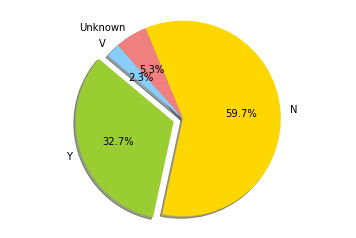

In [56]:
# Data to plot
labels = list(qcount.keys())
sizes = list(qcount.values())
print(sizes)
colors = ['yellowgreen', 'gold',  'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [57]:
# kee
tag = 'QUALITY_RELATED_CD'
thred = 'Y'
Claims_Quality = Claims_Type.loc[lambda Claims_Type: Claims_Type[tag] == thred, :]
print(Claims_Quality.shape, Claims_Quality.head(2))

(73978, 162)                      DIM_CLAIM_TYPE_PK  DIM_CLAIM_STATUS_PK  \
PRIMARY_CUSTOMER_GK                                           
322634                              21                   37   
258724                              21                   37   

                     DIM_CLAIM_REASON_PK  DIM_FINISHED_PRODUCT_SELL_GK  \
PRIMARY_CUSTOMER_GK                                                      
322634                               263                       3835141   
258724                               277                       3835141   

                    SELLING_STYLE_CD SELLING_STYLE_DESC  \
PRIMARY_CUSTOMER_GK                                       
322634                         43518       FASHION ICON   
258724                         43518       FASHION ICON   

                    SELLING_STYLE_SHORT_DESC SELLING_SIZE_CD  \
PRIMARY_CUSTOMER_GK                                            
322634                              FASHIONI            1200   
258724  

In [58]:
class_info(Claims_Quality.CLAIM_STATUS_TYPE_CD)

    50:   33224  =   44.9%
    51:    9023  =   12.2%
    30:   23531  =   31.8%
    21:     116  =    0.2%
    36:     858  =    1.2%
    48:     424  =    0.6%
    14:     321  =    0.4%
    15:     271  =    0.4%
     8:     131  =    0.2%
   nan:     857  =    1.2%
    11:      18  =    0.0%
    45:     432  =    0.6%
    35:      99  =    0.1%
    89:     113  =    0.2%
    17:     138  =    0.2%
    22:     268  =    0.4%
    97:    2048  =    2.8%
    20:     136  =    0.2%
    12:      21  =    0.0%
    80:     590  =    0.8%
    49:     111  =    0.2%
    19:     118  =    0.2%
    46:      42  =    0.1%
    13:      16  =    0.0%
     6:     306  =    0.4%
     7:       7  =    0.0%
    81:      30  =    0.0%
    16:     114  =    0.2%
    18:      33  =    0.0%
    31:      13  =    0.0%
    29:      11  =    0.0%
     9:      91  =    0.1%
    54:       3  =    0.0%
    33:     111  =    0.2%
    52:       8  =    0.0%
    38:      38  =    0.1%
    10:      16  =    0.0%
 

(Counter({'50': 33224,
          '51': 9023,
          '30': 23531,
          '21': 116,
          '36': 858,
          '48': 424,
          '14': 321,
          '15': 271,
          '8': 131,
          nan: 857,
          '11': 18,
          '45': 432,
          '35': 99,
          '89': 113,
          '17': 138,
          '22': 268,
          '97': 2048,
          '20': 136,
          '12': 21,
          '80': 590,
          '49': 111,
          '19': 118,
          '46': 42,
          '13': 16,
          '6': 306,
          '7': 7,
          '81': 30,
          '16': 114,
          '18': 33,
          '31': 13,
          '29': 11,
          '9': 91,
          '54': 3,
          '33': 111,
          '52': 8,
          '38': 38,
          '10': 16,
          '32': 6,
          '63': 5,
          '73': 9,
          '28': 2,
          '83': 3,
          'Unknown': 1,
          '3': 253,
          '53': 2,
          '47': 2,
          '93': 8}),
 [0.4491064911189813,
  0.1219686933953337

In [59]:
# digitalize claim_status data into 1 or 0
# Paid = 1
Claims_Quality.loc[:,'CLAIM_STATUS_TYPE_CD'] = Claims_Quality.loc[:,'CLAIM_STATUS_TYPE_CD'].replace(['48', '49', '50','51'], '1')
# Declined = 0
Claims_Quality.loc[:,'CLAIM_STATUS_TYPE_CD'] = Claims_Quality.loc[:,'CLAIM_STATUS_TYPE_CD'].replace(['30', '35', '36'], '0')
class_info(Claims_Quality.CLAIM_STATUS_TYPE_CD)

     1:   42782  =   57.8%
     0:   24488  =   33.1%
    21:     116  =    0.2%
    14:     321  =    0.4%
    15:     271  =    0.4%
     8:     131  =    0.2%
   nan:     857  =    1.2%
    11:      18  =    0.0%
    45:     432  =    0.6%
    89:     113  =    0.2%
    17:     138  =    0.2%
    22:     268  =    0.4%
    97:    2048  =    2.8%
    20:     136  =    0.2%
    12:      21  =    0.0%
    80:     590  =    0.8%
    19:     118  =    0.2%
    46:      42  =    0.1%
    13:      16  =    0.0%
     6:     306  =    0.4%
     7:       7  =    0.0%
    81:      30  =    0.0%
    16:     114  =    0.2%
    18:      33  =    0.0%
    31:      13  =    0.0%
    29:      11  =    0.0%
     9:      91  =    0.1%
    54:       3  =    0.0%
    33:     111  =    0.2%
    52:       8  =    0.0%
    38:      38  =    0.1%
    10:      16  =    0.0%
    32:       6  =    0.0%
    63:       5  =    0.0%
    73:       9  =    0.0%
    28:       2  =    0.0%
    83:       3  =    0.0%
U

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(Counter({'1': 42782,
          '0': 24488,
          '21': 116,
          '14': 321,
          '15': 271,
          '8': 131,
          nan: 857,
          '11': 18,
          '45': 432,
          '89': 113,
          '17': 138,
          '22': 268,
          '97': 2048,
          '20': 136,
          '12': 21,
          '80': 590,
          '19': 118,
          '46': 42,
          '13': 16,
          '6': 306,
          '7': 7,
          '81': 30,
          '16': 114,
          '18': 33,
          '31': 13,
          '29': 11,
          '9': 91,
          '54': 3,
          '33': 111,
          '52': 8,
          '38': 38,
          '10': 16,
          '32': 6,
          '63': 5,
          '73': 9,
          '28': 2,
          '83': 3,
          'Unknown': 1,
          '3': 253,
          '53': 2,
          '47': 2,
          '93': 8}),
 [0.5783070642623482,
  0.3310173294763308,
  0.0015680337397604694,
  0.00433912784881992,
  0.0036632512368542,
  0.0017707967233501851,
  0.011584

In [69]:
claims_q = Claims_Quality['CLAIM_STATUS_TYPE_CD']
print(claims_q.head(2))
claims_nq = [x if x == '1' or x=='0' else 'others' for x in claims_q.values]
nqcount, nqper = class_info(claims_nq)

PRIMARY_CUSTOMER_GK
322634    1
258724    1
Name: CLAIM_STATUS_TYPE_CD, dtype: object
     1:   42782  =   57.8%
     0:   24488  =   33.1%
others:    6708  =    9.1%


[42782, 24488, 6708]


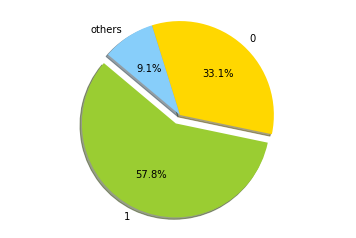

In [70]:
# Data to plot
labels = list(nqcount.keys())
sizes = list(nqcount.values())
print(sizes)
colors = ['yellowgreen', 'gold',  'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [71]:
Claims_Quality =Claims_Quality[pd.notnull(Claims_Quality['CLAIM_STATUS_TYPE_CD'])]
print(Claims_Quality.shape)

(73121, 162)


In [72]:
def _drop_rows(dataModel, tag, thred):    
    # thred can be a numerical or string    
    dataModel_rem = dataModel[dataModel[tag] != thred]
    #print(dataModel_rem.shape)     
    return dataModel_rem

In [73]:
tag = 'CLAIM_STATUS_TYPE_CD'
thred = 'Unknown'
Claims_Quality_q = _drop_rows(Claims_Quality, tag, thred)
print(Claims_Quality_q.shape)

thred = 'E-BUS'
Claims_Quality_q = _drop_rows(Claims_Quality_q, tag, thred)
print(Claims_Quality_q.shape)

(73120, 162)
(73120, 162)


In [74]:
statusType = Claims_Quality_q.loc[:,'CLAIM_STATUS_TYPE_CD']
statusTypeInt = [int(y) for y in statusType]
Claims_Quality_q.loc[:,'CLAIM_STATUS_TYPE_CD'] = statusTypeInt

In [75]:
# only claims = 1 (paid) or 0 (declined)
tag = 'CLAIM_STATUS_TYPE_CD'
upperThred = 1
Claims_Status = Claims_Quality_q.loc[lambda Claims_Quality_q: Claims_Quality_q[tag] <= upperThred,:]
csType = Claims_Status.CLAIM_STATUS_TYPE_CD
csClaim, pclaim = class_info(csType)
print(csClaim, pclaim)

     1:   42782  =   63.6%
     0:   24488  =   36.4%
Counter({1: 42782, 0: 24488}) [0.6359744313958674, 0.3640255686041326]


In [76]:
print(sum(csClaim.values()))

67270


[24488, 42782] [0 1] dict_keys([1, 0])


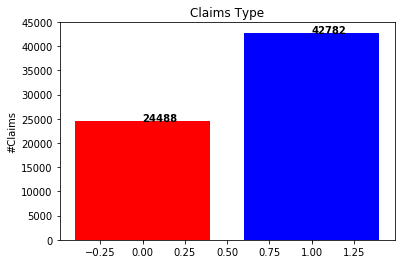

In [77]:
objects = csClaim.keys()
y_pos = np.arange(len(objects))
x_claims = list(csClaim.values())[::-1]
print(x_claims, y_pos, objects)   
_plot_classbar(x_claims, y_pos)

In [78]:
#Claims_Status.to_csv('claimsStatus.csv')
Claims_Status = pd.read_csv('claimsStatus.csv', encoding='latin1') 

C:\anaconda35\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (31,37,38,39,66,69,151) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
claimAMT = Claims_Status.loc[:,'TOTAL_CLAIMS_DOLLAR_AMT']
claimAMTfloat = [float(y) if isinstance(y, (int, float)) else np.nan for y in claimAMT]
Claims_Status.loc[:,'TOTAL_CLAIMS_DOLLAR_AMT'] = claimAMTfloat

In [80]:
Claims_Status.reset_index(inplace=True)
print(Claims_Status.shape, Claims_Status.head(10))

(67269, 165)    index  Unnamed: 0  PRIMARY_CUSTOMER_GK  DIM_CLAIM_TYPE_PK  \
0      0           0               322634                 21   
1      1           1               258724                 21   
2      2           2               293160                 21   
3      3           3               259219                  0   
4      4           4               259219                  0   
5      5           5               259219                 21   
6      6           6               259219                 21   
7      7           7               322634                 21   
8      8           8               251176                  0   
9      9           9               251176                 21   

   DIM_CLAIM_STATUS_PK  DIM_CLAIM_REASON_PK  DIM_FINISHED_PRODUCT_SELL_GK  \
0                   37                  263                       3835141   
1                   37                  277                       3835141   
2                   37                  281        

In [81]:
print(Claims_Status.loc[62346:62348,'TOTAL_CLAIMS_DOLLAR_AMT'])

62346    719.96
62347    253.50
62348     42.48
Name: TOTAL_CLAIMS_DOLLAR_AMT, dtype: float64


In [82]:
claimAMT = Claims_Status.loc[:,'TOTAL_CLAIMS_DOLLAR_AMT']
claimAMT = pd.to_numeric(claimAMT, downcast='float')
Claims_Status.loc[:,'TOTAL_CLAIMS_DOLLAR_AMT'] = claimAMT

In [83]:
num_na = Claims_Status['TOTAL_CLAIMS_DOLLAR_AMT'].dropna()
print(num_na.shape)

(67269,)


In [84]:
Claims_AMT = Claims_Status[Claims_Status['TOTAL_CLAIMS_DOLLAR_AMT']>0]
print(Claims_AMT.shape)

(62658, 165)


In [85]:
tag = 'INVENTORY_BACKING_CD'
count, cper = class_info(Claims_AMT[tag])
tag_unique = set(Claims_AMT[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

    H5:    4439  =    7.1%
    H4:   15648  =   25.0%
     A:   24848  =   39.7%
    K2:       2  =    0.0%
    C1:     980  =    1.6%
    AM:       2  =    0.0%
     I:       5  =    0.0%
     T:     344  =    0.5%
    ED:       4  =    0.0%
     V:    1085  =    1.7%
     W:     719  =    1.1%
    SS:      45  =    0.1%
    VT:    2189  =    3.5%
    SW:     909  =    1.5%
    WA:       2  =    0.0%
    EW:    2630  =    4.2%
    LP:      55  =    0.1%
    T9:     110  =    0.2%
    WM:     786  =    1.3%
    RK:       2  =    0.0%
    VA:     422  =    0.7%
    LX:       8  =    0.0%
    CL:       2  =    0.0%
    BX:       9  =    0.0%
    LG:       4  =    0.0%
    LR:       4  =    0.0%
     P:     662  =    1.1%
    LU:      48  =    0.1%
    GL:     179  =    0.3%
    MD:      99  =    0.2%
    T3:     527  =    0.8%
     K:       4  =    0.0%
    SH:       9  =    0.0%
    CM:      37  =    0.1%
    DC:       1  =    0.0%
    FT:      93  =    0.1%
    BN:      25  =    0.0%
 

In [99]:
back_df = pd.DataFrame(data = list(count.values()), index = list(count.keys()), columns = ['back'])
print(back_df.head(2))

     back
H5   4439
H4  15648


In [107]:
total = sum(list(count.values()))
back_sorted = sorted(back_df.back, reverse=True)
back_sorted = pd.DataFrame(back_sorted, index = back_df.index, columns = ['back'])
back_sorted['percent'] = back_sorted['back']/total
print(back_sorted.head(10))

     back   percent
H5  24848  0.396565
H4  15648  0.249737
A    4439  0.070845
K2   3864  0.061668
C1   2630  0.041974
AM   2189  0.034936
I    1085  0.017316
T     980  0.015640
ED    909  0.014507
V     786  0.012544


In [140]:
#create a summary df
back_nq = back_sorted.loc[lambda back_sorted: back_sorted['percent'] >= 0.03,:]
back_nq5  = sum(list(back_sorted['back'][0:6]))
# add a row 'others'
back_nq.loc['others'] = [total-back_nq5, (total-back_nq5)/total]
print(back_nq.head(7))
#nqback, npback = class_info(back_nq['back'])

           back   percent
H5      24848.0  0.396565
H4      15648.0  0.249737
A        4439.0  0.070845
K2       3864.0  0.061668
C1       2630.0  0.041974
AM       2189.0  0.034936
others   9040.0  0.144275


C:\anaconda35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


[24848.0, 15648.0, 4439.0, 3864.0, 2630.0, 2189.0, 9040.0]


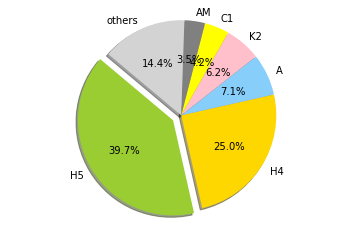

In [141]:
# Data to plot
labels = list(back_nq.index[0:7])
sizes = list(back_nq['back'][0:7])
print(sizes)
colors = ['yellowgreen', 'gold',  'lightskyblue', 'pink', 'yellow','grey','lightgrey']
explode = (0.1, 0, 0, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [142]:
tag = 'INVENTORY_STYLE_CD'
count, cper = class_info(Claims_AMT[tag])
tag_unique = set(Claims_AMT[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

 27778:      88  =    0.1%
 27841:      17  =    0.0%
 27023:       1  =    0.0%
 27021:       4  =    0.0%
 59121:      73  =    0.1%
 26030:     107  =    0.2%
 27490:       2  =    0.0%
 80124:      15  =    0.0%
 27318:      53  =    0.1%
 27416:      17  =    0.0%
 26712:       1  =    0.0%
 26767:       1  =    0.0%
 26690:       1  =    0.0%
 82047:      25  =    0.0%
 27044:       3  =    0.0%
 26778:       3  =    0.0%
 25578:      85  =    0.1%
 27048:     221  =    0.4%
 25532:      67  =    0.1%
 27047:      70  =    0.1%
 25494:      17  =    0.0%
 27011:       6  =    0.0%
 25725:     143  =    0.2%
 25108:      51  =    0.1%
 25110:      68  =    0.1%
 25109:      21  =    0.0%
 25444:     244  =    0.4%
 27522:      61  =    0.1%
 27500:       5  =    0.0%
 25529:      23  =    0.0%
 25556:       1  =    0.0%
 25542:     596  =    1.0%
 25220:      30  =    0.0%
 59116:      23  =    0.0%
 59119:       1  =    0.0%
  G074:       1  =    0.0%
 26721:       3  =    0.0%
 

 88771:       1  =    0.0%
 88772:       1  =    0.0%
 YJ39A:       1  =    0.0%
 88486:       5  =    0.0%
 88609:       2  =    0.0%
 88617:       2  =    0.0%
 88425:       2  =    0.0%
 88482:      11  =    0.0%
 88484:       4  =    0.0%
 88550:       1  =    0.0%
 88558:       5  =    0.0%
 88652:       5  =    0.0%
 88656:       4  =    0.0%
 89277:       8  =    0.0%
 65097:       1  =    0.0%
 66340:     174  =    0.3%
 88808:       1  =    0.0%
 38954:      13  =    0.0%
 H4010:      19  =    0.0%
 H3847:      11  =    0.0%
 28218:      37  =    0.1%
 28219:      49  =    0.1%
 89285:       6  =    0.0%
 89287:       1  =    0.0%
 YJ59A:      15  =    0.0%
 80547:       4  =    0.0%
 80546:       1  =    0.0%
 80545:       1  =    0.0%
 32575:      20  =    0.0%
 32576:      20  =    0.0%
 34667:       1  =    0.0%
 64023:       1  =    0.0%
 64021:       4  =    0.0%
 63075:       7  =    0.0%
 YJ81A:       5  =    0.0%
 YJ81B:       5  =    0.0%
 32348:       2  =    0.0%
 

In [146]:
style_df = pd.DataFrame(data = list(count.values()), index = list(count.keys()), columns = ['styl'])

total = sum(list(count.values()))
style_sorted = sorted(style_df.styl, reverse=True)
style_sorted = pd.DataFrame(style_sorted, index = style_df.index, columns = ['styl'])
style_sorted['percent'] = style_sorted['styl']/total
print(style_sorted.head(10))

       styl   percent
27778  1067  0.017029
27841   596  0.009512
27023   567  0.009049
27021   471  0.007517
59121   462  0.007373
26030   436  0.006958
27490   423  0.006751
80124   423  0.006751
27318   417  0.006655
27416   414  0.006607


In [155]:
tag = 'INVENTORY_COLOR_CD'
count, cper = class_info(Claims_AMT[tag])
tag_unique = set(Claims_AMT[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

   718:     978  =    1.6%
   719:     432  =    0.7%
   726:     322  =    0.5%
   728:     827  =    1.3%
   837:     217  =    0.3%
   841:     209  =    0.3%
   847:      78  =    0.1%
   859:     637  =    1.0%
   918:      38  =    0.1%
   929:     395  =    0.6%
   685:      28  =    0.0%
   723:     273  =    0.4%
   737:     661  =    1.1%
   849:     506  =    0.8%
   882:      54  =    0.1%
   979:     509  =    0.8%
   868:     597  =    1.0%
   526:       8  =    0.0%
   736:     190  =    0.3%
   565:      68  =    0.1%
   575:     134  =    0.2%
   852:     391  =    0.6%
   876:     134  =    0.2%
   878:     607  =    1.0%
   886:       9  =    0.0%
   948:     309  =    0.5%
   988:      47  =    0.1%
   652:       7  =    0.0%
   721:     603  =    1.0%
   724:     188  =    0.3%
   727:     820  =    1.3%
   731:     421  =    0.7%
   761:      84  =    0.1%
   762:      72  =    0.1%
   778:      16  =    0.0%
   938:     159  =    0.3%
   678:      49  =    0.1%
 

 TV082:       5  =    0.0%
  3277:       1  =    0.0%
    21:       5  =    0.0%
    23:       9  =    0.0%
 22656:      38  =    0.1%
  T830:       4  =    0.0%
  T865:       5  =    0.0%
  T994:      12  =    0.0%
    A8:       2  =    0.0%
   779:      11  =    0.0%
  W911:       1  =    0.0%
   318:      23  =    0.0%
   333:      20  =    0.0%
  2036:      20  =    0.0%
  2093:       6  =    0.0%
  2097:       7  =    0.0%
  3346:       5  =    0.0%
  3396:       2  =    0.0%
  3492:       1  =    0.0%
  3846:       5  =    0.0%
  3894:       1  =    0.0%
  2018:       6  =    0.0%
  1733:      15  =    0.0%
  2192:      16  =    0.0%
   195:       7  =    0.0%
  1795:       6  =    0.0%
 226GF:       2  =    0.0%
 226GG:       1  =    0.0%
  3435:       1  =    0.0%
  2133:       4  =    0.0%
 226N7:       1  =    0.0%
 226NB:       4  =    0.0%
 226KB:       3  =    0.0%
  CE41:       2  =    0.0%
  SS26:       2  =    0.0%
  SS29:       3  =    0.0%
  3254:       1  =    0.0%
 

In [156]:
tag = 'INVENTORY_SIZE_CD'
count, cper = class_info(Claims_AMT[tag])
tag_unique = set(Claims_AMT[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

  1200:   47015  =   75.0%
  1500:    1827  =    2.9%
  1306:      46  =    0.1%
   215:     834  =    1.3%
   600:    4611  =    7.4%
   204:       1  =    0.0%
     1:       6  =    0.0%
  1616:     228  =    0.4%
  1224:     278  =    0.4%
   648:     615  =    1.0%
  1212:      12  =    0.0%
   649:     181  =    0.3%
   636:     143  =    0.2%
  1818:      32  =    0.1%
 07A48:      52  =    0.1%
 03A00:     434  =    0.7%
   500:    1771  =    2.8%
   206:      14  =    0.0%
  1106:       2  =    0.0%
  1414:      15  =    0.0%
  1836:      67  =    0.1%
    47:      29  =    0.0%
    54:      16  =    0.0%
04D048:       6  =    0.0%
05A47A:       3  =    0.0%
 2424P:     593  =    0.9%
DISPLA:       2  =    0.0%
 0500D:     148  =    0.2%
    94:       4  =    0.0%
   300:     617  =    1.0%
 02A00:     198  =    0.3%
  32OZ:       5  =    0.0%
   1GL:       3  =    0.0%
   KIT:      15  =    0.0%
  7E7B:       9  =    0.0%
02B09A:       3  =    0.0%
   400:      15  =    0.0%
 

In [160]:
size_df = pd.DataFrame(data = list(count.values()), index = list(count.keys()), columns = ['size'])
print(size_df.head(2))
total = sum(list(count.values()))
size_sorted = sorted(size_df['size'], reverse=True)
size_sorted = pd.DataFrame(size_sorted, index = size_df.index, columns = ['size'])
size_sorted['percent'] = size_sorted['size']/total
print(size_sorted.head(10))

       size
1200  47015
1500   1827
       size   percent
1200  47015  0.750343
1500   4611  0.073590
1306   1827  0.029158
215    1771  0.028265
600     834  0.013310
204     617  0.009847
1       615  0.009815
1616    593  0.009464
1224    434  0.006926
648     332  0.005299


In [161]:
#create a summary df
size_nq = size_sorted.loc[lambda size_sorted: size_sorted['percent'] >= 0.02,:]
size_nq5  = sum(list(size_sorted['size'][0:4]))
# add a row 'others'
size_nq.loc['others'] = [total-size_nq5, (total-size_nq5)/total]
print(size_nq.head(7))
#nqback, npback = class_info(back_nq['back'])

           size   percent
1200    47015.0  0.750343
1500     4611.0  0.073590
1306     1827.0  0.029158
215      1771.0  0.028265
others   7434.0  0.118644


C:\anaconda35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


[47015.0, 4611.0, 1827.0, 1771.0, 7434.0]


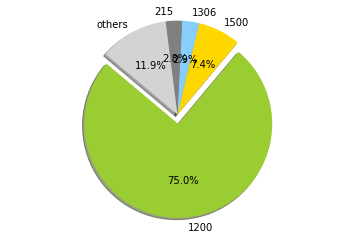

In [163]:
# Data to plot
labels = list(size_nq.index[0:5])
sizes = list(size_nq['size'][0:5])
print(sizes)
colors = ['yellowgreen', 'gold',  'lightskyblue', 'grey','lightgrey']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [68]:
class MultiColumnLabelEncoder(LabelEncoder):
    """
    Wraps sklearn LabelEncoder functionality for use on multiple columns of a
    pandas dataframe.

    """
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, dframe):
        """
        Fit label encoder to pandas columns.

        Access individual column classes via indexig `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            for idx, column in enumerate(self.columns):
                # fit LabelEncoder to get `classes_` for the column
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                # append this column's encoder
                self.all_encoders_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return self

    def fit_transform(self, dframe):
        """
        Fit label encoder and return encoded labels.

        Access individual column classes via indexing
        `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`

        Access individual column encoded labels via indexing
        `self.all_labels_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            self.all_labels_ = np.ndarray(shape=self.columns.shape,
                                          dtype=object)
            for idx, column in enumerate(self.columns):
                # instantiate LabelEncoder
                le = LabelEncoder()
                # fit and transform labels in the column
                dframe.loc[:, column] =\
                    le.fit_transform(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
                self.all_labels_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                dframe.loc[:, column] = le.fit_transform(
                        dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return dframe

    def transform(self, dframe):
        """
        Transform labels to normalized encoding.
        """
        if self.columns is not None:
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[
                    idx].transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .transform(dframe.loc[:, column].values)
        return dframe.loc[:, self.columns].values

    def inverse_transform(self, dframe):
        """
        Transform labels back to original encoding.
        """
        if self.columns is not None:
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .inverse_transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .inverse_transform(dframe.loc[:, column].values)
        return dframe

NameError: name 'LabelEncoder' is not defined

In [71]:
from sklearn.preprocessing import LabelEncoder
def _encode_label(data, tag):
    number = LabelEncoder()
       
    #encode_label = [number.fit_transform(x) if isinstance(x, str) else x for x in data[tag]]
    encode_label = number.fit_transform(data[tag].astype('str'))
    
    data.loc[:,tag] = encode_label
    return data, number

In [118]:
#import label_encoder
def _encode_label_(data, tag, encoder = None):
    df = pd.DataFrame(data[tag], index = data.index, columns=[tag])
    
    if encoder is None:
        encoder = label_encoder()
        encoder.fit_pd(df)

    encode_label = encoder.transform_pd(df)
    
    data.loc[:,tag] = encode_label
    return data, encoder

In [87]:
def _convert_dummy(data, tag):
    dummy_train = pd.get_dummies(data[tag].astype('str'))
    return dummy_train    

In [109]:
tag = 'INVENTORY_STYLE_CD'
Claims_AMT, encoder_style = _encode_label(Claims_AMT, tag)
Claims_AMT[tag].head(10)
dummy_style = _convert_dummy(Claims_AMT, tag)
dummy_style.head(10)

,0,1,10,100,1000,1001,1002,1003,1004,1005,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Testing new label_encoder function

In [113]:
def _convert_float(data, tag):
    df = data[tag]
    float_list = [float(x) for x in df]
    #float_list = pd.DataFrame(float_list, index = data.index, columns = data.columns)
    data[tag]=float_list
    return data

In [111]:
tag = 'INVENTORY_STYLE_CD'
Claims_AMTn, encoder_style_ = _encode_label_(Claims_AMT, tag)
Claims_AMTn[tag].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: INVENTORY_STYLE_CD, dtype: int64

In [114]:
tag = 'INVENTORY_BACKING_CD'
Claims_AMTn, encoder_back_ = _encode_label_(Claims_AMTn, tag)
Claims_AMTn[tag].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: INVENTORY_BACKING_CD, dtype: int64

In [115]:
tag = 'INVENTORY_SIZE_CD'
Claims_AMTn, encoder_size_ = _encode_label_(Claims_AMTn, tag)
Claims_AMTn[tag].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: INVENTORY_SIZE_CD, dtype: int64

In [116]:
tag = 'INVENTORY_COLOR_CD'
Claims_AMTn, encoder_color_ = _encode_label_(Claims_AMTn, tag)
Claims_AMTn[tag].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: INVENTORY_COLOR_CD, dtype: int64

In [112]:
#test
test_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/SmartClaim/Data/claim_input.csv'
testData = pd.read_csv(test_dataPath, encoding='latin1')  # Read the claims data
print(testData.head(2), testData.shape)

   Unnamed: 0  CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD  \
0           0    7128208              27949              1200   
1           1    7128013              27949              1200   

  INVENTORY_BACKING_CD INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    CLAIM  \
0                    A                728                    299832   635.70   
1                    A              81336                    299832  1501.67   

   TOTAL_CLAIM  TOTAL_CLAIM_CNT  TRX_CNT  NET_SALES  
0       666.08                3       58  952219.01  
1      1574.24                4       26  221429.41   (326, 12)


In [117]:
# testing new data for encoder
INPUT_TAGS = ['numClaims',
              'numSales',
              'dollarPerClaim',
              'dollarPerSale',
              'claimRatio',
              'INVENTORY_STYLE_CD',
              'INVENTORY_SIZE_CD',
              'INVENTORY_BACKING_CD',
              'INVENTORY_COLOR_CD'
              ]

testData.rename(columns={'TOTAL_CLAIM_CNT': 'numClaims', 'TRX_CNT': 'numSales', 
                         'TOTAL_CLAIM':'dollarClaims', 'NET_SALES':'dollarSales'}, inplace=True)
tagList = ['numClaims', 'numSales','dollarClaims', 'dollarSales']
        
for item in tagList:
    testData = _convert_float(testData, item)

modelData = testData
modelData['dollarPerClaim'] = modelData['dollarClaims']/modelData['numClaims']
modelData['dollarPerSale'] = modelData['dollarSales']/modelData['numSales']
modelData['claimRatio'] = modelData['dollarClaims']/modelData['dollarSales']
        
print(modelData.head(4), modelData.shape)
        
#import input tags
#modelData_inf = _replace_inf(modelData)
X = modelData[INPUT_TAGS]

   Unnamed: 0  CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD  \
0           0    7128208              27949              1200   
1           1    7128013              27949              1200   
2           2    7128223              27931              1200   
3           3    7132728              32519              0500   

  INVENTORY_BACKING_CD INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    CLAIM  \
0                    A                728                    299832   635.70   
1                    A              81336                    299832  1501.67   
2                    A                740                    299832   346.01   
3                   EW                 96                    251961    54.97   

   dollarClaims  numClaims  numSales  dollarSales  dollarPerClaim  \
0        666.08        3.0      58.0    952219.01      222.026667   
1       1574.24        4.0      26.0    221429.41      393.560000   
2        226.38        1.0      30.0    305721.91      226.380000 

In [121]:
#encodeing
tag_style = 'INVENTORY_STYLE_CD'
X, numb_style = _encode_label_(X, tag_style, encoder_style_)
        
tag_back = 'INVENTORY_BACKING_CD'
X, numb_back = _encode_label_(X, tag_back,encoder_back_)
        
tag_size = 'INVENTORY_SIZE_CD'
X, numb_size = _encode_label_(X, tag_size, encoder_size_)
        
tag_color = 'INVENTORY_COLOR_CD'
X, numb_color = _encode_label_(X, tag_color, encoder_color_)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [122]:
print(X.head(400))

     numClaims  numSales  dollarPerClaim  dollarPerSale  claimRatio  \
0          3.0      58.0      222.026667   16417.569138    0.000700   
1          4.0      26.0      393.560000    8516.515769    0.007109   
2          1.0      30.0      226.380000   10190.730333    0.000740   
3          7.0      25.0       79.394286    5011.930000    0.004435   
4          2.0      89.0      776.315000    4927.125056    0.003541   
5          1.0      13.0     3249.490000    2275.264615    0.109860   
6          1.0      18.0     6456.020000    8576.111111    0.041822   
7          2.0     156.0      202.710000    1760.732436    0.001476   
8          2.0     174.0      583.500000    1948.712471    0.003442   
9          4.0      91.0      725.267500    4622.957802    0.006896   
10         1.0      76.0      157.400000     710.905263    0.002913   
11         4.0     212.0      681.882500    2178.914481    0.005905   
12         4.0     100.0      370.420000    1023.925300    0.014471   
13    

In [124]:
# Saving the encoder parameters:
with open(fmodelPara, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([encoder_style_, encoder_back_, encoder_size_, encoder_color_], f)

# Test get dummy function

In [91]:
tag = ['INVENTORY_STYLE_CD','INVENTORY_BACKING_CD', 'INVENTORY_SIZE_CD', 'INVENTORY_COLOR_CD']
dummy_res = _convert_dummy(Claims_AMT, tag)
dummy_res.head(10)
dummy_res.shape

(62658, 4458)

In [93]:
df_dummy = pd.get_dummies(data=Claims_AMT, columns=tag)
print(df_dummy.head(2))

   index  Unnamed: 0  PRIMARY_CUSTOMER_GK  DIM_CLAIM_TYPE_PK  \
0      0           0               322634                 21   
1      1           1               258724                 21   

   DIM_CLAIM_STATUS_PK  DIM_CLAIM_REASON_PK  DIM_FINISHED_PRODUCT_SELL_GK  \
0                   37                  263                       3835141   
1                   37                  277                       3835141   

  SELLING_STYLE_CD SELLING_STYLE_DESC SELLING_STYLE_SHORT_DESC  \
0            43518       FASHION ICON                 FASHIONI   
1            43518       FASHION ICON                 FASHIONI   

            ...            INVENTORY_COLOR_CD_2134 INVENTORY_COLOR_CD_2135  \
0           ...                                  0                       0   
1           ...                                  0                       0   

  INVENTORY_COLOR_CD_2136 INVENTORY_COLOR_CD_2137 INVENTORY_COLOR_CD_2138  \
0                       0                       0               

In [73]:
tag = 'INVENTORY_BACKING_CD'
Claims_AMT, encoder_back = _encode_label(Claims_AMT, tag)
Claims_AMT[tag].head(100)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0      32
1      32
2      32
3      32
4      32
5      32
6      32
7      32
8      32
9      32
10     32
12     32
13     32
14     32
16     32
17     32
18     32
19     32
20     32
21     32
23     32
24     32
25     32
26     32
27     32
28     32
29     32
30     32
31     32
32     32
       ..
78      4
79      4
81      4
82      4
83      4
84      4
85      4
87      4
88      4
89      4
90      4
91      4
92      4
93      4
94      4
95      4
96      4
97      4
98      4
99      4
100     4
101     4
102     4
103     4
104     4
105     4
106     4
107     4
108     4
109     4
Name: INVENTORY_BACKING_CD, Length: 100, dtype: int64

In [74]:
tag = 'INVENTORY_SIZE_CD'
Claims_AMT, encoder_size = _encode_label(Claims_AMT, tag)
Claims_AMT[tag].head(100)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0      34
1      34
2      34
3      34
4      34
5      34
6      34
7      34
8      34
9      34
10     34
12     34
13     34
14     34
16     34
17     34
18     34
19     34
20     34
21     34
23     34
24     34
25     34
26     34
27     34
28     34
29     34
30     34
31     34
32     34
       ..
78     34
79     34
81     34
82     34
83     34
84     34
85     34
87     34
88     34
89     34
90     34
91     34
92     34
93     34
94     34
95     34
96     34
97     34
98     34
99     34
100    34
101    34
102    34
103    34
104    34
105    34
106    34
107    34
108    34
109    34
Name: INVENTORY_SIZE_CD, Length: 100, dtype: int64

In [75]:
tag = 'INVENTORY_COLOR_CD'
Claims_AMT, encoder_color = _encode_label(Claims_AMT, tag)
Claims_AMT[tag].head(100)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0      1195
1      1195
2      1195
3      1195
4      1195
5      1195
6      1195
7      1195
8      1195
9      1195
10     1196
12     1196
13     1196
14     1196
16     1196
17     1242
18     1242
19     1242
20     1242
21     1242
23     1245
24     1245
25     1245
26     1411
27     1417
28     1417
29     1417
30     1417
31     1417
32     1417
       ... 
78     1430
79     1457
81     1457
82     1457
83     1457
84     1457
85     1457
87     1459
88     1480
89     1480
90     1480
91     1480
92     1480
93     1480
94     1550
95     1550
96     1592
97     1592
98     1592
99     1592
100    1592
101    1121
102    1121
103    1221
104    1221
105    1237
106    1237
107    1237
108    1244
109    1249
Name: INVENTORY_COLOR_CD, Length: 100, dtype: int64

In [ ]:
Claims_Class = pd.DataFrame({'numClaims': Claims_AMT.groupby(["PRIMARY_CUSTOMER_GK", "CLAIM_STATUS_TYPE_CD", 
                                                              "INVENTORY_STYLE_CD", "INVENTORY_SIZE_CD", "INVENTORY_BACKING_CD",
                                                              "INVENTORY_COLOR_CD"]).size()}).reset_index()
print(Claims_Class.shape, Claims_Class.head(20))

In [ ]:
Claims_Dollar = pd.DataFrame({'dollarClaims': Claims_AMT.groupby(["PRIMARY_CUSTOMER_GK", "CLAIM_STATUS_TYPE_CD", 
                                                              "INVENTORY_STYLE_CD", "INVENTORY_SIZE_CD", "INVENTORY_BACKING_CD",
                                                              "INVENTORY_COLOR_CD"])['TOTAL_CLAIMS_DOLLAR_AMT'].sum()}).reset_index()
Claims_Dollar = Claims_Dollar.drop("CLAIM_STATUS_TYPE_CD", axis=1)
print(Claims_Dollar.shape, Claims_Dollar.head(20))

In [ ]:
dropList = ['INVENTORY_STYLE_CD','INVENTORY_SIZE_CD','INVENTORY_BACKING_CD', 'INVENTORY_COLOR_CD']
Claims_Classb = Claims_Class.drop(dropList, axis = 1)
#Claims_Classb.reset_index(inplace=True)
print(Claims_Classb.head(2))
num_Dollar = sum(Claims_Class.numClaims)
print(num_Dollar)

In [ ]:
Claims_Dollar = Claims_Dollar.set_index('PRIMARY_CUSTOMER_GK')
Claims_Class = Claims_Classb.set_index('PRIMARY_CUSTOMER_GK')
Claims_Con = pd.concat([Claims_Class, Claims_Dollar], axis=1)
print(Claims_Con.head(2), Claims_Con.shape)

In [ ]:
customer_unique = set(customerSale.index)
uniqueCnt = len(customer_unique)
print(uniqueCnt) 

In [ ]:
claims_unique = set(Claims_Con.index)
uniqueCnt = len(claims_unique)
print(uniqueCnt) 

# Combine Claims and Sales data

In [ ]:
#Claims_Customer = Claims_Type.join(ClaimCustomer, rsuffix = '_customer')
Claims_Customer = pd.concat([Claims_Con, customerSale, customerName], axis=1, join_axes = [Claims_Con.index])
Claims_Customer = Claims_Customer.rename(columns={"CLAIM_STATUS_TYPE_CD": "Claims"})
print(Claims_Customer.shape, Claims_Customer.head(5))

In [ ]:
tagList = list(Claims_Customer.head(1).columns.values)
print(tagList, len(tagList))

In [ ]:
tagList1 = [x for x in tagList if "_reason" not in x]
tagList2 = [x for x in tagList1 if "_status" not in x]
tagList3 = [x for x in tagList2 if "_type" not in x]
tagList = [x for x in tagList3 if "_customer" not in x]
print(tagList, len(tagList))

In [ ]:
# save data into csv file
ClaimData = Claims_Customer[tagList]
ClaimData.to_csv(fprocData)
print(ClaimData.shape)

# Claim Data Processing
Building the recommendation/scoring model from Customer angle. Factors used in the modeling:
- Customer Name
- SLS = Sales
- TOTAL_CLAIMS_DOLLAR_AMT = $Claims

Derivated variables:
 - Total claims each customer in past year = #claim
 - Dollars each claim each customer = $/claim
 
 - Total sales each customer = SLS
 - Dollars per sale each customer = $/sale
 - Claim to sale ratio = claim/SLS
 
Product variables:
 - Product size
 - Product style
 - Product Color
 - Product Backing

In [ ]:
# read consildated claim data
ClaimData = pd.read_csv(fprocData, encoding='latin1') # Read the data
print(ClaimData.columns)

In [ ]:
remove_list = ['FISCAL_YR_NUM',
       'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'CUSTOMER_NUM',
       'CUSTOMER_SUFFIX_NUM', 'SLS']
for item in remove_list:
    ClaimData = ClaimData.drop(item, axis=1)
    
print(ClaimData.shape, ClaimData.head(2))

In [ ]:
# filter data to have SLS > 10
customerData_SLS = ClaimData[ClaimData["dollarSales"]>100]
sns.distplot(customerData_SLS["dollarSales"])
print(customerData_SLS.shape)

In [ ]:
sns.distplot(customerData_SLS["dollarClaims"])

In [ ]:
# filter data to have TOTAL_CLAIMS_DOLLAR_AMT > 1
customerData_AMT = customerData_SLS[ClaimData['dollarClaims']>0]
sns.distplot(customerData_AMT['dollarClaims'])
print(customerData_AMT.shape)

In [ ]:
def _plot_scatter(data, xTag, yTag):
    # Set style of scatterplot
    #sns.set_context("notebook", font_scale=1.1)
    #sns.set_style("ticks")
    from itertools import cycle
    color_gen = cycle(('blue', 'lightgreen', 'red', 'purple', 'gray', 'cyan'))

    # Create scatterplot of dataframe
    fig = plt.figure(figsize=(11,4)) 
    plt.scatter(data[xTag], # Horizontal axis
               data[yTag], # Vertical axis
               c = next(color_gen))

    # Set title
    plt.title(yTag + ' vs ' + xTag)

    # Set x-axis label
    plt.xlabel(xTag)

    # Set y-axis label
    plt.ylabel(yTag)
    plt.show()

xTag = 'dollarClaims'
yTag = 'dollarSales'
_plot_scatter(ClaimData, xTag, yTag)

In [ ]:
_plot_scatter(customerData_SLS, xTag, yTag)

In [ ]:
_plot_scatter(customerData_AMT, xTag, yTag)

In [ ]:
index_nan = ClaimData['dollarClaims'].index[ClaimData['dollarClaims']<100]
print(index_nan.shape)

In [ ]:
index_nan2 = customerData_SLS['dollarClaims'].index[customerData_SLS['dollarClaims']<0]
print(index_nan2.shape)

In [ ]:
customerData = customerData_AMT.groupby(['CUSTOMER_NAME', 'dollarClaims']).sum()
print(customerData.shape)

In [ ]:
ClaimData = customerData_AMT
#create a pivot table to reshape the data, using sum or count function
claimDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='dollarClaims', aggfunc=sum)
print(claimDollar.head(2), claimDollar.shape)

In [ ]:
claimDollar_na = claimDollar.dropna(axis=0, how = 'any')
print(claimDollar_na.shape)

In [ ]:
#create a pivot table to reshape the data, using sum or count function
"""
saleNumber = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=len)
saleNumber = saleNumber.rename(columns = {'SLS':'NumberSales'})
saleDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=sum)
print(saleDollar.head(2), saleDollar.shape)
"""

In [ ]:
#saleDollar_na = saleDollar.dropna(axis = 0, how = 'any')
#print(saleDollar_na.shape)

In [ ]:
#saleData = pd.concat([saleDollar_na, saleNumber], axis=1, join_axes=[saleDollar_na.index])
#saleData['DollarPerSale'] = saleData['SLS']/saleData['NumberSales']
#print(saleData.shape, saleData.head(2))

In [ ]:
#customerData = pd.concat([saleData, claimDollar_na], axis=1, join_axes=[saleData.index])
#customerData['ClaimRatio'] = customerData['TOTAL_CLAIMS_DOLLAR_AMT']/customerData['SLS']
#print(customerData.shape, customerData.head(2))

In [ ]:
#create a pivot table to reshape the data, using sum or count function
#claimCnt = ClaimData.pivot_table(index='CUSTOMER_NAME', values='TOTAL_CLAIMS_DOLLAR_AMT', aggfunc=len)
#claimCnt = claimCnt.rename(columns = {'TOTAL_CLAIMS_DOLLAR_AMT':'Total_Claims'})
#print(claimCnt.head(2), claimCnt.shape)

In [ ]:
# join count claim
#modelData = pd.concat([customerData, claimCnt], axis=1, join_axes=[customerData.index])
modelData = ClaimData
modelData['dollarPerClaim'] = modelData['dollarClaims']/modelData['numClaims']
modelData['dollarPerSale'] = modelData['dollarSales']/modelData['numSales']
modelData['claimRatio'] = modelData['dollarClaims']/modelData['dollarSales']
print(modelData.shape, modelData.head(2))

In [ ]:
modelData.reset_index(inplace=False)
print(modelData.head(20), modelData.shape)

In [ ]:
xTag = 'numSales'
yTag = 'numClaims'
_plot_scatter(modelData, xTag, yTag)

In [ ]:
 ax = sns.regplot(x=xTag, y=yTag, data=modelData)

# Visualization of modeling data

In [ ]:
print(modelData.shape, modelData.head(2))

In [ ]:
#sns.lmplot(x="SLS", y="ClaimRatio", data=modelData, hue="ClaimRatio", fit_reg=False, size = 8);
#series plot over three sigma

yName = "dollarClaims"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
yName = "claimRatio"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
# ClaimAMT = 0
CR0 = modelData[modelData["claimRatio"]==0]
print(CR0.shape)

In [ ]:
LargeCR = modelData[modelData["claimRatio"] > 1]
print(LargeCR.shape)

In [ ]:
modelData_tmp = modelData[modelData['claimRatio'] < 1]
data = modelData_tmp['claimRatio']
sns.distplot(data, bins=30)
plt.show()

In [ ]:
LargeDPS= modelData[modelData["dollarPerSale"] > 1000]
print(LargeDPS.shape)

In [ ]:
tag = 'dollarPerSale'
modelData_tmp = modelData[modelData[tag] < 10000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
tag = 'numSales'
LargeS= modelData[modelData[tag] > 10]
print(LargeS.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
LargeDPC= modelData[modelData["dollarPerClaim"] > 1000]
print(LargeDPC.shape)

In [ ]:
tag = 'dollarPerClaim'
modelData_tmp = modelData[modelData[tag] < 1000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
tag = 'dollarClaims'
LargeC= modelData[modelData[tag] > 10]
print(LargeC.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
yName = "dollarSales"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
yName = "dollarPerClaim"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
n, bins, patches = plt.hist(xd, bins='auto', facecolor='green', alpha=0.75)
print(xd.describe())

In [ ]:
# box plot
plt.hist(np.array(modelData['claimRatio']), color=['r'], alpha=0.5, label='claimRatio')
plt.legend(loc='upper right')
plt.show()

In [ ]:
_plot_boxplot(np.array(modelData['claimRatio']))

In [ ]:
#series plot over three sigma
yName = "claimRatio"
ifactor = 3
xd = modelData[yName]
_plot_QQ(xd) 

In [ ]:
import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
#pd.set_option('display.width', 1000)

In [ ]:
# save data into csv file
modelData.to_csv(fmodelData)
print(modelData.shape, modelData.head(2))
class_info(modelData.Claims)

In [ ]:
modelData.drop(['Unnamed: 0', 'index'], inplace=True, axis = 1)
print(modelData.head(5))

In [ ]:
modelData_gk = modelData.set_index('PRIMARY_CUSTOMER_GK')
print(modelData_gk.head(5))

# Preprocess inputs to model Claim Scoring

Possible Inputs:
- ClaimRatio
- DollarPerClaim ($/claim)

- DollarPerSale ($/sale)
- #Sales
- #Claims

In [ ]:
# read consildated model data
modelData = pd.read_csv(fmodelData, encoding='latin1') # Read the data
print(modelData.columns, modelData.head(5))

In [ ]:
# Normalize data
    # manually selected tags -- no normalized or PCA
def _read_inputTags():
    inputTags = ['numClaims',
                 'numSales',
                 'dollarPerClaim',
                 'dollarPerSale',
                 'claimRatio',
                 'INVENTORY_STYLE_CD',
                 'INVENTORY_SIZE_CD',
                 'INVENTORY_BACKING_CD',
                 'INVENTORY_COLOR_CD'
                ]
    return inputTags

inputTags = _read_inputTags()
yTags = 'Claims'

In [ ]:
customerID = modelData['CUSTOMER_NAME']
X = modelData[inputTags]
y = modelData[yTags]

print(X.head(2), X.shape)

In [ ]:
csClaim, pclaim = class_info(y)

In [ ]:
objects = csClaim.keys()
y_pos = np.arange(len(objects))
x_claims = list(csClaim.values())[::-1] 
_plot_classbar(x_claims, y_pos)

In [ ]:
# split data
ts = 0.3
xTrain, xTest, yTrain, yTest = train_test_split(X, y, stratify=y, test_size=ts, random_state=531)  

In [ ]:
# normalize data
xvalue = xTrain.values 
normX_scaler = preprocessing.StandardScaler().fit(xvalue) 
xScaled = normX_scaler.transform(xvalue)   
xScaled_test = normX_scaler.transform(xTest.values) 
xnTrain = pd.DataFrame(xScaled)
xnTest = pd.DataFrame(xScaled_test)

In [ ]:
xnTrain.index = xTrain.index
xnTrain.columns = xTrain.columns
xnTest.index = xTest.index
xnTest.columns = xTest.columns

In [ ]:
class_info(yTrain)
class_info(yTest)

In [ ]:
#split the training data into modeling set and validation set
nxModel, nxValid, yModel, yValid = train_test_split(xnTrain, yTrain, stratify=yTrain, test_size=ts, random_state=531)
class_info(yModel)
class_info(yValid)

# Modeling using Different Methods

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import accuracy_score

In [ ]:
# <codecell>

# let's switch to 2-dimensional curves; specifically, the ROC and precision-recall curves.
# Define two functions to plot ROC and Precision-Recall curves.

def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure()
    aucs = []
    all_tpr = []
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X.iloc[train,:], y[train]).predict_proba(X.iloc[test,:])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        all_tpr.append(mean_tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random', alpha=0.8)
    
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), 
         lw=2, alpha=0.8)
    
    std_tpr = np.std(all_tpr, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha=0.2,
                     label = r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return classifier
  

In [ ]:
xm = nxModel.iloc[:, 3:5]
#xm = pd.DataFrame(xm)
print(xm.head(2))
n_features = X.shape[1]

C = 1.0
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

In [ ]:
# Create different classifiers. The logistic regression cannot do
# multiclass out of the box.
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1'),
               'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2'),
               'RBF SVC': SVC(kernel='rbf', C=C, class_weight='balanced',probability=True,
                                 random_state=0),
               'Linear SVC': SVC(kernel='linear', C=C, class_weight='balanced',probability=True,
                                 random_state=0),
               'L2 logistic (Multinomial)': LogisticRegression(
                C=C, solver='lbfgs', multi_class='multinomial')
               #'GPC': GaussianProcessClassifier(kernel)
               }

n_classifiers = len(classifiers)

In [ ]:
plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(xm, yModel)

    y_pred = classifier.predict(xm)
    classif_rate = np.mean(y_pred.ravel() == yModel.ravel()) * 100
    print("classif_rate for %s : %f " % (name, classif_rate))

    # View probabilities=
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(xm.iloc[idx,0], xm.iloc[idx,1], marker='o', c='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

In [ ]:
def _verify_claim(classifier, xValid, yValid):
    
    y_pred = classifier.predict(xValid)
    classif_rate = np.mean(y_pred.ravel() == yValid.ravel()) * 100
    print("classif_rate for %s : %f \n" % (name, classif_rate))

    # Output probabilities
    valFull = np.c_[xValid, yValid]
    probas = classifier.predict_proba(xValid)
    
    test_results = [Declined', 'Paid']   
    print ("\nModel Report")
    print(classification_report(yValid, y_pred, target_names= test_results))
    print("Predicted Declined Claims = %s" %sum(column_or_1d(y_pred)))
    print ("Accuracy : %.4g" % accuracy_score(yValid.values, y_pred))
    
    # output results
    proba = pd.DataFrame(data=probas[:,0], index = yValid.index, columns = ['Score'])
    yPred = pd.DataFrame(data=y_pred, index = yValid.index, columns = ['Pred'])
    res_pred = pd.concat([yValid, yPred, proba], axis=1)
    return res_pred    

In [ ]:
for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(nxModel, yModel)
    res_pred = _verify_claim(classifier, nxValid, yValid)

In [ ]:
print(res_pred.head(20), res_pred.shape)

# Plot claim scoring data

In [ ]:
# read consildated claim data
fscoreData = 'C:/Users/E154709/Desktop/Mohawk/Claims/eclf_output.csv'
claimScore = pd.read_csv(fscoreData, encoding='latin1') # Read the data
print(claimScore.head(5), claimScore.shape)

In [ ]:
claimScore = claimScore.rename(columns={"Unnamed: 0": "Customer_GK", "Index": "Type"})
sortScore = claimScore.sort_values(by='Score')
sortScore.reset_index(inplace = True)
sns.lmplot(x="Item", y="Score", data=sortScore, hue="Pred", fit_reg=False, size = 8);
sns.lmplot(x="Item", y="Score", data=sortScore, hue="Claims", fit_reg=False, size = 8);

In [ ]:
#sortScore = sortScore.drop('level_0', axis = 1)
print(sortScore.head(5), sortScore.shape)

In [ ]:
sns.lmplot(x = "dollarPerSale", y="Score", data=sortScore, hue="Claims", fit_reg=False, size = 8);

In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=False)

In [ ]:
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="Claims", y="Score", data=sortScore, hue="Pred", split=True,
               inner="quart", palette={1: 'b', 0: 'r'})
sns.despine(left=True)

In [ ]:
# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="Claims", y="Score", data=sortScore, hue="Pred", palette="PRGn")
sns.despine(offset=10, trim=True)